In [1]:
# Import dependencies
import os
import pandas as pd

In [31]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from pydub import AudioSegment
from tqdm import tqdm

In [3]:
voiced_dataset = "resources/voiced_dataset/"

In [4]:
# Get all the files in the directory
files = os.listdir(voiced_dataset)

# Create lists to check dataset
voice_info = []
voice_file = []

# Loop through each file
for file in files:
    # Look through voice files only
    if file.startswith("voice"):
        
        # Isolate the info text files
        if file.endswith("-info.txt"):
            voice_id = file.split("-")[0]
            voice_info.append(voice_id)
        
        # Isolate the voice text files
        elif file.endswith(".txt"):
            voice_id = file.split(".")[0]
            voice_file.append(voice_id)

# Confirm each sample has a signal and info file
print(f'Info File: {len(voice_info)}')
print(f'Signal File: {len(voice_file)}')

Info File: 208
Signal File: 208


In [5]:
# Read in the raw data as a signal using wfdb
for file in files:
    if file.startswith("voice") and file.endswith("-info.txt"):
        voice_id = file.split("-")[0]
        record_name = voiced_dataset + voice_id
        record = wfdb.rdrecord(record_name)
        
        # Access the signal data
        signal_data = record.p_signal
        
        # Access the metadata from the header
        sampling_frequency = record.fs
        signal_names = record.sig_name
        
        # print(f'Sampling frequency: {sampling_frequency} Hz') # all 8000 Hz
        # print(f'Signal name: {signal_names}') # all voice files
        
        # Plot the signal data
        # plt.figure(figsize=(12, 6))
        # plt.plot(signal_data)
        # plt.title('Signal Data')
        # plt.xlabel('Sample Index')
        # plt.ylabel('Amplitude')
        # plt.show()

In [7]:
# Audio data, meaning signed (32-)bit integer
signed_32bit = 2**31 - 1

# Convert to a wav file
for file in files:
    # Extract .hea files only
    if file.startswith("voice") and not file.endswith("-info.txt") and file.endswith(".hea"):
        voice_id = file.split(".")[0]
        record_name = voiced_dataset + voice_id
        
        # Read the wfdb record
        record = wfdb.rdrecord(record_name)
        
        # Access the signal data and its fs (sampling freq)
        signal_data = record.p_signal
        fs = record.fs
        
        # Find the min and max of the signal data
        signal_min = np.min(signal_data)
        signal_max = np.max(signal_data)
        
        # Normalise and scale to 32-bit range
        normalised_signal = (signal_data - signal_min) / (signal_max - signal_min)
        normalised_signal = (signed_32bit * normalised_signal).astype(np.int32)

        # Create an AudioSegment from the normalized signal data
        audio_segment = AudioSegment(
            normalised_signal.tobytes(),
            frame_rate = fs,
            sample_width = 4,
            channels = 1
        )

        # Save the AudioSegment as a WAV file
        output_filename = f'resources/audio_files/{voice_id}.wav'
        audio_segment.export(output_filename, format='wav')

## Convert info text file to dataframe

In [8]:
# Initialise the list to hold the dictionaries
metadata_list = []

# Parse the data in the info files
for file in files:
    # Initialise the dictionary to store the info
    voice_metadata = dict()

    # Look through info files only
    if file.startswith("voice") and file.endswith("-info.txt"):
        # Read the text file
        with open(voiced_dataset + file, 'r') as file:
            for line in file:
                # print(line.strip())
                
                # Split each line into a key, value pair using delimiter
                key, value = map(str.strip, line.split('\t'))
                
                # Ignore the empty lines by checking whitespaces
                if not line.strip():
                    continue
                else:
                    # Remove the colon
                    key = key.replace(":", "")
                    
                    # Load the data to a dictionary
                    voice_metadata[key] = value
            
            # Append the dictionary to the list
            metadata_list.append(voice_metadata)

# Display the list of dictionaries
metadata_list

[{'ID': 'voice100',
  'Age': '24',
  'Gender': 'm',
  'Diagnosis': 'healthy',
  'Occupation status': 'NU',
  'Voice Handicap Index (VHI) Score': '0',
  'Reflux Symptom Index (RSI) Score': '5',
  'Smoker': 'no',
  'Number of cigarettes smoked per day': 'NU',
  'Alcohol consumption': 'casual drinker',
  'Number of glasses containing alcoholic beverage drinked in a day': 'NU',
  "Amount of water's litres drink every day": '1,5',
  'Eating habits': '',
  'Carbonated beverages': 'almost always',
  'Amount of glasses drinked in a day': 'NU',
  'Tomatoes': 'never',
  'Coffee': 'always',
  'Number of cups of coffee drinked in a day': '3',
  'Chocolate': 'sometimes',
  'Gramme of chocolate eaten in  a day': 'NU',
  'Soft cheese': 'almost always',
  'Gramme of soft cheese eaten in a day': 'NU',
  'Citrus fruits': 'never',
  'Number of citrus fruits eaten in a day': 'NU'},
 {'ID': 'voice101',
  'Age': '60',
  'Gender': 'm',
  'Diagnosis': 'healthy',
  'Occupation status': 'NU',
  'Voice Handicap 

In [9]:
# Convert the info contents to a DataFrame
metadata_df = pd.DataFrame(metadata_list)
metadata_df.head()

,ID,Age,Gender,Diagnosis,Occupation status,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Smoker,Number of cigarettes smoked per day,Alcohol consumption,...,Amount of glasses drinked in a day,Tomatoes,Coffee,Number of cups of coffee drinked in a day,Chocolate,Gramme of chocolate eaten in a day,Soft cheese,Gramme of soft cheese eaten in a day,Citrus fruits,Number of citrus fruits eaten in a day
0,voice100,24,m,healthy,NU,0,5,no,NU,casual drinker,...,NU,never,always,3,sometimes,NU,almost always,NU,never,NU
1,voice101,60,m,healthy,NU,80,10,no,NU,nondrinker,...,NU,sometimes,always,4,sometimes,NU,sometimes,NU,never,NU
2,voice192,22,m,hyperkinetic dysphonia,Cook,0,10,no,NU,nondrinker,...,NU,sometimes,always,NU,always,NU,sometimes,NU,almost always,NU
3,voice193,46,f,hyperkinetic dysphonia,Housewife,0,36,yes,15,casual drinker,...,NU,sometimes,always,2,sometimes,NU,sometimes,NU,sometimes,NU
4,voice008,51,f,reflux laryngitis,Researcher,19,15,no,NU,casual drinker,...,NU,almost always,always,2,almost always,20g,sometimes,100 gr,almost always,1


In [76]:
metadata_df['Diagnosis'].value_counts()

Diagnosis
healthy                                                57
hyperkinetic dysphonia                                 43
reflux laryngitis                                      38
hypokinetic dysphonia                                  22
hyperkinetic dysphonia (Prolapse)                       9
hypokinetic dysphonia (glottic insufficiency)           6
hyperkinetic dysphonia (Polyps)                         5
hypokinetic dysphonia (Vocal fold paralysis)            4
hyperkinetic dysphonia (Reinke's edema)                 3
hyperkinetic dysphonia (nodule)                         3
hyperkinetic dysphonia (Nodule)                         2
hypokinetic dysphonia (Extraglottic air leak)           1
hypokinetic dysphonia (Glottic insufficiency)           1
hypokinetic dysphonia (Dysphonia by chordal groove)     1
hyperkinetic dysphonia (polyps)                         1
hyperkinetic dysphonia (Adduction deficit)              1
hypokinetic dysphonia (Adduction deficit)               1
hypo

In [77]:
metadata_df['Occupation status'].value_counts()

Occupation status
Researcher              43
NU                      41
Employee                25
Housewife               23
Student                 16
Technical operator      14
Singer                  10
Pensioner                6
Doctor                   5
Teacher                  4
Merchant                 4
Hairstylist              2
Secretary                2
Unemployed               1
Male nurse               1
Cook                     1
Comptroller              1
Call center operator     1
Auto electrician         1
Fireman                  1
Beautician               1
Driver                   1
Blacksmith               1
Italian police           1
Librarian                1
Cobbler                  1
Name: count, dtype: int64

In [130]:
metadata_df['Age'].value_counts()

Age
55    8
38    7
22    7
46    7
39    7
26    7
23    7
49    6
43    6
32    6
30    6
70    6
53    6
51    5
34    5
35    5
47    5
36    5
50    5
45    5
56    5
57    5
42    5
44    5
31    4
54    4
60    4
58    4
63    4
64    3
48    3
62    3
24    3
52    3
33    3
27    3
59    3
65    3
21    3
66    2
61    2
67    2
41    2
29    2
20    1
25    1
18    1
28    1
68    1
69    1
40    1
Name: count, dtype: int64

## Feature Extraction Test - TSFEL

In [75]:
import tsfel

## Feature Extraction Test - pyAcoustics

In [10]:
from pyAudioAnalysis import audioBasicIO, ShortTermFeatures

In [74]:
audio_path = "resources/audio_files/"
audio_files = os.listdir(audio_path)

# Create a list to hold the dictionaries
st_features_list = []

# for wav in tqdm(audio_files, desc="Processing wav files"):
for wav in audio_files:
    # Confirm wav file and not .DS_Store, etc.
    if wav.split(".")[1] == "wav":
        # Create dictionary to hold features
        st_features = dict()

        # Get the voice_id
        voice_id = wav.split(".")[0]

        fs, signal_data = audioBasicIO.read_audio_file(audio_path + wav)
        features, feature_names = ShortTermFeatures.feature_extraction(
            signal_data,
            sampling_frequency,
            0.050 * sampling_frequency,
            0.025 * sampling_frequency,
            deltas = False # disable deltas features
        )

        # Populate the dictionary
        st_features['ID'] = voice_id
        # for feature, name in zip(features, feature_names):
            # print(len(feature), name)
        # for idx, feature_name in enumerate(feature_names):
            # st_features[feature_name] = features[:,idx]
        print(feature_names[1], len(features[1]))

        # Append the dictionary to a list
        st_features_list.append(st_features)

energy 189
energy 189
energy 189
energy 189
energy 189
energy 187
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 187
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 187
energy 187
energy 189
energy 189
energy 189
energy 191
energy 187
energy 189
energy 189
energy 189
energy 187
energy 189
energy 189
energy 189
energy 187
energy 189
energy 189
energy 187
energy 189
energy 187
energy 189
energy 187
energy 187
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 187
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 187
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 189
energy 191
energy 187
energy 189
energy 189
energy 187
energy 189
energy 189


KeyboardInterrupt: 

In [57]:
# Convert to a DataFrame
features_df = pd.DataFrame(st_features_list)
features_df.head()

,ID,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,...,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,chroma_std
0,voice094,"[0.0, 6.036956937561178e-07, 3.321928094885631...","[0.0, 6.036956937561178e-07, 3.321928094885631...","[0.0, 6.036956937561178e-07, 3.321928094885631...","[0.11027568922305764, 7.778260870361641e-05, 1...","[0.2932330827067669, 0.00042691523980716294, 2...","[0.3659147869674185, 0.001357235690262895, 3.0...","[0.3659147869674185, 0.0021349800961519096, 3....","[0.3458646616541353, 0.0028115622279735273, 3....","[0.3258145363408521, 0.004331934259933998, 3.2...",...,"[0.3157894736842105, 0.020688177182017754, 3.2...","[0.2882205513784461, 0.01989808627419934, 3.23...","[0.3007518796992481, 0.02132430860567962, 3.25...","[0.3258145363408521, 0.02233029033385263, 3.28...","[0.3533834586466165, 0.023894035543074895, 3.2...","[0.3609022556390977, 0.02489596508132603, 3.26...","[0.3208020050125313, 0.024121379294441705, 3.2...","[0.3032581453634085, 0.023989630239194155, 3.2...","[0.3182957393483709, 0.02657629453541623, 3.27...","[0.3182957393483709, 0.0292940846037663, 3.310..."
1,voice080,"[0.0, 6.725083325735506e-07, 3.321928094885808...","[0.0, 6.725083325735506e-07, 3.321928094885808...","[0.0, 6.725083325735506e-07, 3.321928094885808...","[0.06015037593984962, 0.0016422332313299807, 0...","[0.16040100250626566, 0.009796031122571377, 2....","[0.19298245614035087, 0.02080344356479361, 3.2...","[0.18796992481203006, 0.0277590231664838, 3.26...","[0.19799498746867167, 0.03711472610293278, 3.2...","[0.19799498746867167, 0.04202613844610546, 3.2...",...,"[0.12531328320802004, 0.09303688016125582, 3.2...","[0.12781954887218044, 0.09487553648657428, 3.3...","[0.13032581453634084, 0.08935307825055863, 3.3...","[0.12781954887218044, 0.08360435530667815, 3.2...","[0.12781954887218044, 0.07924530178512848, 3.2...","[0.14536340852130325, 0.07847711793011576, 3.3...","[0.15288220551378445, 0.07839772051416488, 3.2...","[0.13784461152882205, 0.08296598214882119, 3.2...","[0.12781954887218044, 0.08832773544567932, 3.2...","[0.13784461152882205, 0.08934096050748373, 3.3..."
2,voice057,"[0.0, 3.999052524692604e-07, 3.321928094884751...","[0.0, 3.999052524692604e-07, 3.321928094884751...","[0.0, 3.999052524692604e-07, 3.321928094884751...","[0.03007518796992481, 0.001468924393143278, 0....","[0.11027568922305764, 0.009091193387989702, 2....","[0.15789473684210525, 0.018562732516125932, 3....","[0.16290726817042606, 0.024577466989902864, 3....","[0.16541353383458646, 0.031226880791165722, 3....","[0.16541353383458646, 0.035758696879457805, 3....",...,"[0.13032581453634084, 0.06595727025093107, 3.1...","[0.13283208020050125, 0.0707250285801621, 3.20...","[0.13533834586466165, 0.06624732179881722, 3.2...","[0.13032581453634084, 0.06178957436097808, 3.2...","[0.12781954887218044, 0.07035581658945649, 3.2...","[0.13283208020050125, 0.07240824688744914, 3.2...","[0.13283208020050125, 0.06489645251343963, 3.1...","[0.13283208020050125, 0.06279236500728076, 3.2...","[0.13784461152882205, 0.06271203063596108, 3.2...","[0.14285714285714285, 0.06479076416548836, 3.2..."
3,voice043,"[0.0, 4.083981747468871e-06, 3.321928094887106...","[0.0, 4.083981747468871e-06, 3.321928094887106...","[0.0, 4.083981747468871e-06, 3.321928094887106...","[0.040100250626566414, 0.0013738755601153338, ...","[0.14285714285714285, 0.007637042152530581, 2....","[0.19298245614035087, 0.01702832071801264, 3.2...","[0.19047619047619047, 0.02717411625636095, 3.2...","[0.19799498746867167, 0.03916976477987911, 3.2...","[0.20300751879699247, 0.04780566600377423, 3.3...",...,"[0.15037593984962405, 0.07554585780947477, 3.3...","[0.14786967418546365, 0.0722211722398066, 3.31...","[0.14285714285714285, 0.07207392252144769, 3.3...","[0.15037593984962405, 0.08073794533769017, 3.3...","[0.16541353383458646, 0.08418123258006595, 3.3...","[0.15789473684210525, 0.07820

In [63]:
features_df['mfcc_1'][0]

array([ 3.25814536e-01,  4.33193426e-03,  3.23784752e+00,  4.28884228e-01,
        2.80924848e-01,  2.63987978e+00,  2.49830471e-03,  7.95000000e-01,
       -2.51726792e+01,  3.53729848e-02, -1.66842996e-01,  1.10862375e+00,
        8.18680048e-01,  5.82976226e-01,  4.86506318e-02, -7.05600822e-02,
        2.19132676e-01, -6.79182115e-01,  2.27197777e-01,  6.37412387e-02,
       -8.53340437e-02,  3.37277974e-03,  9.20765890e-03,  8.88697665e-03,
        7.24972078e-03,  2.82050866e-03,  8.89750115e-04,  2.14059211e-02,
        4.03236694e-03,  2.73416344e-03,  7.18954640e-02,  7.70004439e-03,
        3.41069247e-03,  1.87965259e-02])

In [40]:
test_file = audio_path + "voice094.wav"
fs, signal_data = audioBasicIO.read_audio_file(test_file)
features, feature_names = ShortTermFeatures.feature_extraction(
    signal_data,
    sampling_frequency,
    0.050 * sampling_frequency,
    0.025 * sampling_frequency,
    deltas = False
)

In [41]:
feature_names

['zcr',
 'energy',
 'energy_entropy',
 'spectral_centroid',
 'spectral_spread',
 'spectral_entropy',
 'spectral_flux',
 'spectral_rolloff',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'chroma_1',
 'chroma_2',
 'chroma_3',
 'chroma_4',
 'chroma_5',
 'chroma_6',
 'chroma_7',
 'chroma_8',
 'chroma_9',
 'chroma_10',
 'chroma_11',
 'chroma_12',
 'chroma_std']

## Feature Extraction Test - MFCCs (Librosa)

In [79]:
import librosa
import librosa.display

In [ ]:
# Define constants
sampling_rate = 8000 # from dataset homepage, 8000Hz sampling frequency

In [ ]:
# Initialise a list to hold the mfccs
mfcc_list = []

# Read in the raw data as a signal using wfdb
for file in files:
    if file.startswith("voice") and file.endswith("-info.txt"):
        voice_id = file.split("-")[0]
        record_name = voiced_dataset + voice_id
        
        record = wfdb.rdrecord(record_name)
        
        # Access the signal data
        signal_data = record.p_signal
        
        # Access the metadata from the header
        sampling_frequency = record.fs
        
        # Get the MFCCs
        mfccs = librosa.feature.mfcc(
            y = signal_data,
            sr = sampling_frequency
        )
        
        # Flatten the array
        flat_mfccs = np.ravel(mfccs)
        
        # Append to the list
        mfcc_list.append(flat_mfccs)
        
        # Check process
        print(voice_id, end='', flush=True)

In [ ]:
# Add the mfcc_list to the existing dataframe
metadata_df['mfcc'] = pd.Series(mfcc_list)
metadata_df.head()

In [ ]:
# Check the mfcc column
metadata_df['mfcc'][0]

In [ ]:
plt.figure()
librosa.display.specshow(mfccs.squeeze(), x_axis = 'time')
plt.colorbar()
plt.title('MFCCs')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

In [86]:
import parselmouth

In [118]:
test_file = audio_path + "voice094.wav"
audio_segment = AudioSegment.from_wav(test_file)

# Convert the pydub AudioSegment to a byte array
# audio_bytes = audio_segment.raw_data

audio_array = np.array(audio_segment.get_array_of_samples())

# Create a parselmouth Sound object from the numpy array
sound = parselmouth.Sound(
    audio_array,
    sampling_frequency = 8000)

# Extract formants
formants = sound.to_formant_burg()

# print(formants)

pitch = sound.to_pitch()
pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")
print(str(pulses).strip())

Object type: PointProcess
Object name: untitled_untitled
Date: Thu Dec 21 15:34:52 2023

Time domain:
   Start time: 0 seconds
   End time: 4.76 seconds
   Total duration: 4.76 seconds
Number of times: 465
First time: 0.14973992715144552 seconds
Last time: 4.743493136260253 seconds
Periods between 0.1 ms and 20 ms (pitch between 50 and 10000 Hz),
with a maximum "period factor" of 1.3:
     Number of periods: 463
     Mean period: 0.0063159268144655405 seconds
     Stdev period: 0.0009866693378695714 seconds
     Jitter (local): 3.120%
     Jitter (local, absolute): 197.059E-6 seconds
     Jitter (rap): 1.844%
     Jitter (ppq5): 1.925%
     Jitter (ddp): 5.532%
All periods:
     Number of periods: 464
     Mean period: 0.009900330192044842 seconds
     Stdev period: 0.07721670212927258 seconds
     Jitter (local): 74.467478%
     Jitter (local, absolute): 7372.526198E-6 seconds
     Jitter (rap): 49.594714%
     Jitter (ppq5): 59.581758%
     Jitter (ddp): 148.784142%


In [80]:
# for wav in tqdm(audio_files, desc="Processing wav files"):
for wav in audio_files:
    # Confirm wav file and not .DS_Store, etc.
    if wav.split(".")[1] == "wav":
        # Create dictionary to hold features
        st_features = dict()

        # Get the voice_id
        voice_id = wav.split(".")[0]
        
        # Load the signal
        signal, sample_rate = librosa.load(audio_path + wav)

        # Calculate the formants
        formants, frequencies = librosa.effects.formants(signal, sr = sample_rate)
        
        print(formants, frequencies)

KeyboardInterrupt: 

/var/folders/ty/2_dklc2s4llcw6m5n02lv30h0000gn/T/ipykernel_13218/2581799349.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))  # Use log scale for better visualization


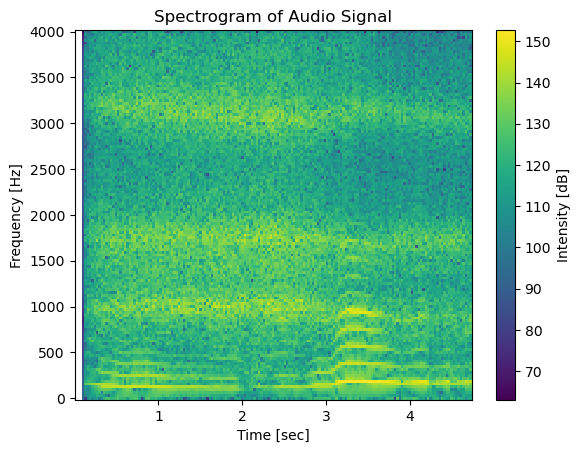

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram

# Load the WAV file
sampling_rate, audio_data = wavfile.read(test_file)

# Create a spectrogram
frequencies, times, Sxx = spectrogram(audio_data, fs=sampling_rate)

# Sxx = Sxx + 1e-10 # Add a small constant to avoid division by zero

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))  # Use log scale for better visualization
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Audio Signal')
plt.colorbar(label='Intensity [dB]')
# plt.show()

# Specify the desired pixel size (width, height) in inches
dpi = 100

# Save the spectrogram as an image file with the specified dpi
output_file = 'spectrogram_image.png'
plt.savefig(output_file, dpi=dpi)

# Show the plot (optional)
plt.show()

/var/folders/ty/2_dklc2s4llcw6m5n02lv30h0000gn/T/ipykernel_13218/3010327980.py:7: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  Sxx = librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max)


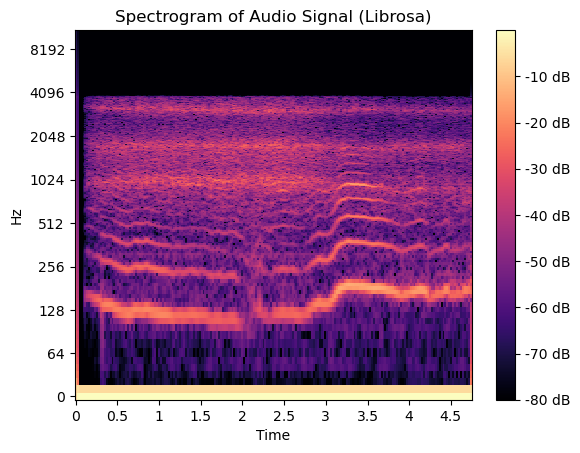

In [121]:
import librosa.display

# Load the WAV file with librosa
audio_data, sampling_rate = librosa.load(test_file)

# Create a spectrogram with librosa
Sxx = librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max)

# Plot the spectrogram
librosa.display.specshow(Sxx, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Audio Signal (Librosa)')
plt.show()
